In [49]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pour rééquilibrage (SMOTE)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Modèles de classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import joblib


In [50]:
donnee_modelisation = pd.read_csv('donnees_ademe_finales_nettoyees_69_final_pret.csv')
donnee_modelisation.shape

(434380, 21)

In [75]:
donnee_modelisation.head(3)

,conso_auxiliaires_ef,cout_eclairage,conso_5_usages_par_m2_ef,emission_ges_ecs,conso_5_usages_ef,surface_habitable_logement,cout_ecs,cout_auxiliaires,type_batiment,conso_ecs_ef,emission_ges_5_usages,etiquette_ges,etiquette_dpe,cout_total_5_usages,conso_refroidissement_ef,type_energie_recodee
0,860.4,66.4,203.0,759.3,27197.3,133.6,214.2,248.2,maison,2343.4,5919.305,E,E,2693.3,0.0,Fioul domestique
1,0.0,15.3,294.0,87.1,23582.8,50.1,219.7,0.0,maison,1339.8,1379.900,C,G,2619.4,0.0,Autres
2,754.2,63.1,51.0,59.6,8533.5,146.3,187.2,154.0,maison,916.6,646.900,A,C,1743.0,0.0,Electricite


In [52]:
donnee_modelisation = donnee_modelisation.drop(columns=['date_reception_dpe', 'code_postal_ban', 'adresse_norm', 'latitude','longitude'])

In [53]:
donnee_modelisation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434380 entries, 0 to 434379
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   conso_auxiliaires_ef        434380 non-null  float64
 1   cout_eclairage              434380 non-null  float64
 2   conso_5_usages_par_m2_ef    434380 non-null  float64
 3   emission_ges_ecs            434380 non-null  float64
 4   conso_5_usages_ef           434380 non-null  float64
 5   surface_habitable_logement  434380 non-null  float64
 6   cout_ecs                    434380 non-null  float64
 7   cout_auxiliaires            434380 non-null  float64
 8   type_batiment               434380 non-null  object 
 9   conso_ecs_ef                434380 non-null  float64
 10  emission_ges_5_usages       434380 non-null  float64
 11  etiquette_ges               434380 non-null  object 
 12  etiquette_dpe               434380 non-null  object 
 13  cout_total_5_u

In [54]:
donnee_modelisation['etiquette_dpe'].value_counts()

etiquette_dpe
C    163436
D    132788
E     73988
F     24280
B     17937
G     15193
A      6758
Name: count, dtype: int64

## preparation 

In [66]:
# Variables cibles
target_class = 'etiquette_dpe'
target_reg = 'cout_total_5_usages'

# Séparation X / y
X = donnee_modelisation.drop(columns=[target_class, target_reg])
y_class = donnee_modelisation[target_class]
y_reg = donnee_modelisation[target_reg]

# Colonnes numériques et catégorielles
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipelines de transformation
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ])


## classification

In [35]:
# Dictionnaire des modèles de classification et leurs hyperparamètres
models_class = {
    "LogisticRegression": (
        LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial'),
        {
            "classifier__C": [0.1, 1, 10],
            "classifier__solver": ['lbfgs']
        }
    ),
    "DecisionTree": (
        DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        {
            "classifier__max_depth": [None, 5, 10, 20],
            "classifier__min_samples_split": [2, 5, 10]
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42, class_weight='balanced'),
        {
            "classifier__n_estimators": [100, 300],
            "classifier__max_depth": [None, 10, 20]
        }
    )
}


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.3, random_state=42, stratify=y_class
)


best_models_class = {}

for name, (model, params) in models_class.items():
    print(f"\n Optimisation du modèle de classification : {name}")

    # Pipeline avec SMOTE pour équilibrer les classes
    pipe = ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", model)
    ])

    grid = GridSearchCV(
        pipe,
        param_grid=params,
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )

    grid.fit(X_train, y_train)
    best_models_class[name] = grid.best_estimator_

    print(f" Meilleurs paramètres : {grid.best_params_}")
    print(f" Score CV : {grid.best_score_:.4f}")



 Optimisation du modèle de classification : LogisticRegression


c:\Users\Surface\Documents\Master SISE\ML Python\Projet ML\data\projet-ml\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


 Meilleurs paramètres : {'classifier__C': 10, 'classifier__solver': 'lbfgs'}
 Score CV : 0.8624

 Optimisation du modèle de classification : DecisionTree
 Meilleurs paramètres : {'classifier__max_depth': None, 'classifier__min_samples_split': 5}
 Score CV : 0.9678

 Optimisation du modèle de classification : RandomForest
 Meilleurs paramètres : {'classifier__max_depth': None, 'classifier__n_estimators': 300}
 Score CV : 0.9774



===  Évaluation du modèle : LogisticRegression ===
 Accuracy globale : 0.8630

 Rapport de classification :
              precision    recall  f1-score   support

           A       0.80      0.94      0.87      2027
           B       0.70      0.89      0.78      5381
           C       0.94      0.91      0.92     49031
           D       0.89      0.82      0.85     39837
           E       0.83      0.86      0.84     22196
           F       0.66      0.78      0.72      7284
           G       0.74      0.83      0.78      4558

    accuracy                           0.86    130314
   macro avg       0.79      0.86      0.82    130314
weighted avg       0.87      0.86      0.86    130314



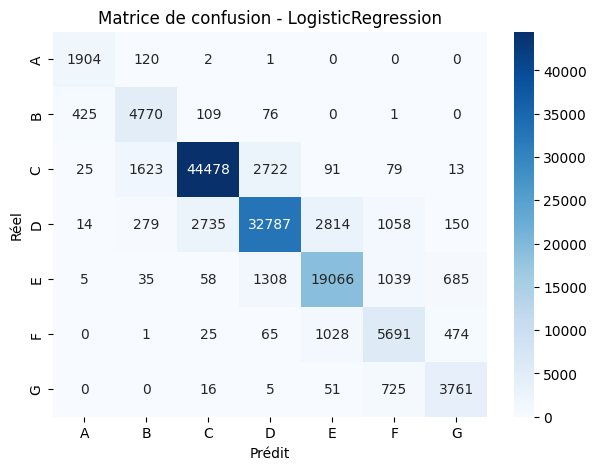


===  Évaluation du modèle : DecisionTree ===
 Accuracy globale : 0.9694

 Rapport de classification :
              precision    recall  f1-score   support

           A       0.96      0.98      0.97      2027
           B       0.96      0.97      0.96      5381
           C       0.99      0.99      0.99     49031
           D       0.98      0.97      0.97     39837
           E       0.96      0.96      0.96     22196
           F       0.90      0.90      0.90      7284
           G       0.91      0.93      0.92      4558

    accuracy                           0.97    130314
   macro avg       0.95      0.96      0.95    130314
weighted avg       0.97      0.97      0.97    130314



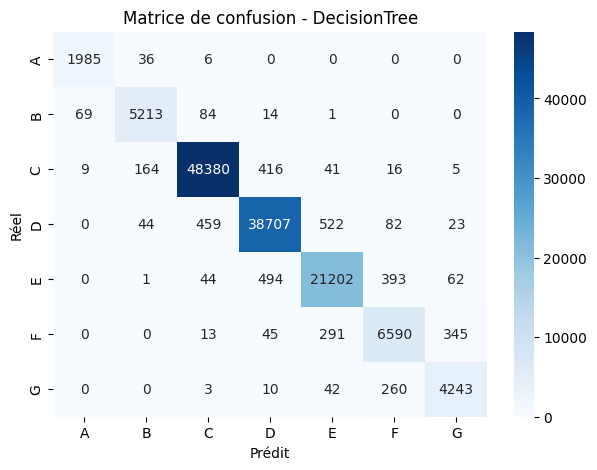


===  Évaluation du modèle : RandomForest ===
 Accuracy globale : 0.9789

 Rapport de classification :
              precision    recall  f1-score   support

           A       0.98      0.98      0.98      2027
           B       0.96      0.98      0.97      5381
           C       0.99      0.99      0.99     49031
           D       0.98      0.98      0.98     39837
           E       0.97      0.97      0.97     22196
           F       0.93      0.93      0.93      7284
           G       0.95      0.94      0.94      4558

    accuracy                           0.98    130314
   macro avg       0.97      0.97      0.97    130314
weighted avg       0.98      0.98      0.98    130314



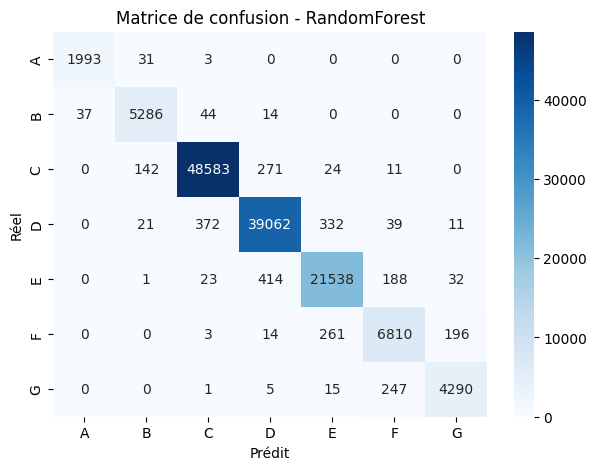


 Classement des modèles de classification :
               Modèle  Accuracy
2        RandomForest  0.978882
1        DecisionTree  0.969351
0  LogisticRegression  0.862969


In [37]:
# ÉVALUATION DÉTAILLÉE POUR CHAQUE MODÈLE


results = []

for name, model in best_models_class.items():
    print(f"\n===  Évaluation du modèle : {name} ===")
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f" Accuracy globale : {acc:.4f}\n")
    
    print(" Rapport de classification :")
    print(classification_report(y_test, y_pred))
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred, labels=sorted(y_class.unique()))
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=sorted(y_class.unique()),
                yticklabels=sorted(y_class.unique()))
    plt.title(f"Matrice de confusion - {name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()
    
    results.append((name, acc))

# Résumé comparatif
results_df = pd.DataFrame(results, columns=['Modèle', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
print("\n Classement des modèles de classification :")
print(results_df)


In [38]:
# SÉLECTION ET SAUVEGARDE DU MEILLEUR MODÈLE

best_class_name = results_df.iloc[0]['Modèle']
best_class_model = best_models_class[best_class_name]

print(f"\n Meilleur modèle de classification : {best_class_name}")
joblib.dump(best_class_model, f"best_model_classification_{best_class_name}.pkl")
print(f" Modèle sauvegardé : best_model_classification_{best_class_name}.pkl")



 Meilleur modèle de classification : RandomForest
 Modèle sauvegardé : best_model_classification_RandomForest.pkl


#### Bon modele de classification en se limitant seulement au random forest

In [56]:
# Dictionnaire des modèles de classification et leurs hyperparamètres
models_class = {
        "RandomForest": (
        RandomForestClassifier(random_state=42, class_weight='balanced'),
        {
            "classifier__n_estimators": [0, 100, 300],
            "classifier__max_depth": [None, 10, 20]
        }
    )
}


In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.3, random_state=42, stratify=y_class
)


best_models_class = {}

for name, (model, params) in models_class.items():
    print(f"\n Optimisation du modèle de classification : {name}")

    # Pipeline avec SMOTE pour équilibrer les classes
    pipe = ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", model)
    ])

    grid = GridSearchCV(
        pipe,
        param_grid=params,
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )

    grid.fit(X_train, y_train)
    best_models_class[name] = grid.best_estimator_

    print(f" Meilleurs paramètres : {grid.best_params_}")
    print(f" Score CV : {grid.best_score_:.4f}")



 Optimisation du modèle de classification : RandomForest


c:\Users\Surface\Documents\Master SISE\ML Python\Projet ML\data\projet-ml\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Surface\Documents\Master SISE\ML Python\Projet ML\data\projet-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Surface\Documents\Master SISE\ML Python\Projet ML\data\projet-ml\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(

 Meilleurs paramètres : {'classifier__max_depth': None, 'classifier__n_estimators': 100}
 Score CV : 0.9798



===  Évaluation du modèle : RandomForest ===
 Accuracy globale : 0.9806

 Rapport de classification :
              precision    recall  f1-score   support

           A       0.98      0.98      0.98      2027
           B       0.97      0.99      0.98      5381
           C       0.99      0.99      0.99     49031
           D       0.98      0.98      0.98     39837
           E       0.97      0.97      0.97     22196
           F       0.94      0.94      0.94      7284
           G       0.95      0.95      0.95      4558

    accuracy                           0.98    130314
   macro avg       0.97      0.97      0.97    130314
weighted avg       0.98      0.98      0.98    130314



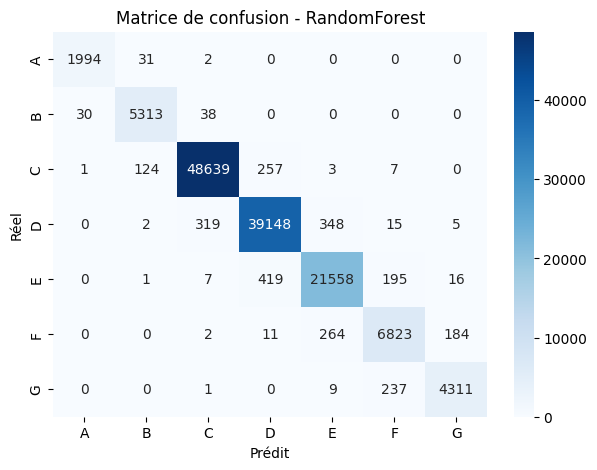


 Classement des modèles de classification :
         Modèle  Accuracy
0  RandomForest  0.980601


In [58]:
# ÉVALUATION DÉTAILLÉE POUR CHAQUE MODÈLE


results = []

for name, model in best_models_class.items():
    print(f"\n===  Évaluation du modèle : {name} ===")
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f" Accuracy globale : {acc:.4f}\n")
    
    print(" Rapport de classification :")
    print(classification_report(y_test, y_pred))
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred, labels=sorted(y_class.unique()))
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=sorted(y_class.unique()),
                yticklabels=sorted(y_class.unique()))
    plt.title(f"Matrice de confusion - {name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()
    
    results.append((name, acc))

# Résumé comparatif
results_df = pd.DataFrame(results, columns=['Modèle', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
print("\n Classement des modèles de classification :")
print(results_df)


In [83]:
# Récupération des noms de variables après transformation
feature_names = best_class_model.named_steps["preprocessor"].get_feature_names_out()

In [84]:
importances = best_class_model.named_steps["classifier"].feature_importances_


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

feat_imp = pd.DataFrame({
    'Variable': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp.head(20))

                                             Variable  Importance
2                       num__conso_5_usages_par_m2_ef    0.305732
16                               cat__etiquette_ges_C    0.062287
9                          num__emission_ges_5_usages    0.054871
3                               num__emission_ges_ecs    0.052583
4                              num__conso_5_usages_ef    0.052351
22              cat__type_energie_recodee_Electricite    0.044806
1                                 num__cout_eclairage    0.044131
14                               cat__etiquette_ges_A    0.041848
15                               cat__etiquette_ges_B    0.040776
6                                       num__cout_ecs    0.039361
8                                   num__conso_ecs_ef    0.036699
17                               cat__etiquette_ges_D    0.033096
5                     num__surface_habitable_logement    0.030134
19                               cat__etiquette_ges_F    0.028567
18        

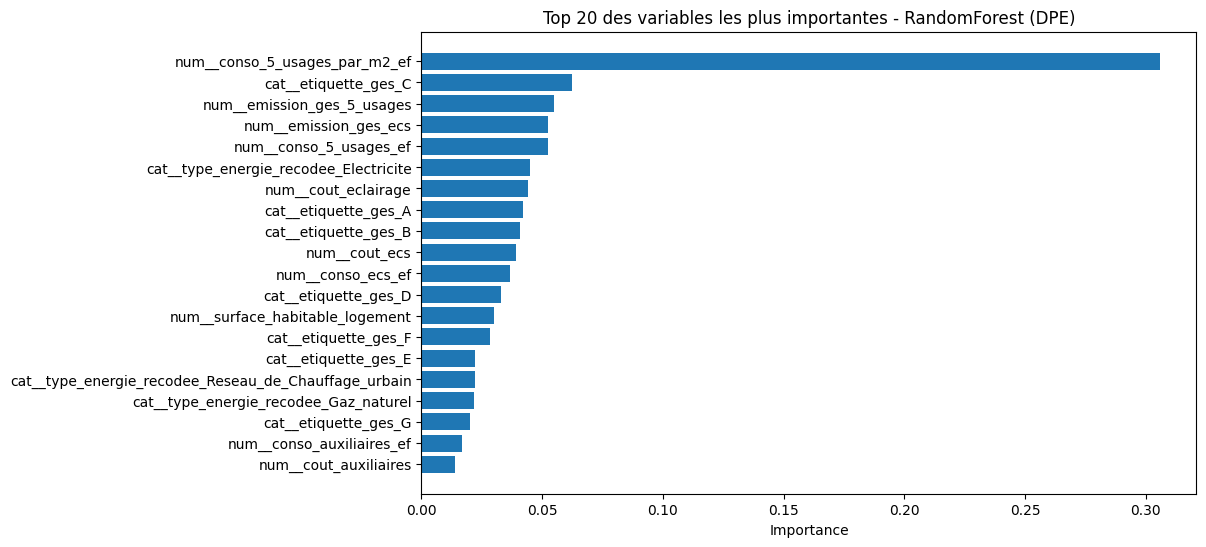

In [86]:
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Variable'].head(20), feat_imp['Importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 des variables les plus importantes - RandomForest (DPE)")
plt.xlabel("Importance")
plt.show()


In [59]:
# SÉLECTION ET SAUVEGARDE DU MEILLEUR MODÈLE

best_class_name = results_df.iloc[0]['Modèle']
best_class_model = best_models_class[best_class_name]

print(f"\n Meilleur modèle de classification : {best_class_name}")
joblib.dump(best_class_model, f"best_model_classification_{best_class_name}.pkl")
print(f" Modèle sauvegardé : best_model_classification_{best_class_name}.pkl")



 Meilleur modèle de classification : RandomForest
 Modèle sauvegardé : best_model_classification_RandomForest.pkl


## regression

In [63]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error


In [64]:
models_reg = {
    "LinearRegression": (
        LinearRegression(),
        {}
    ),
    "DecisionTreeRegressor": (
        DecisionTreeRegressor(random_state=42),
        {
            "regressor__max_depth": [None, 5, 10, 20, 30, 40, 50],
            "regressor__min_samples_split": [2, 5, 10, 15, 20],
            "regressor__min_samples_leaf": [1, 2, 4]
        }
    )
}


In [67]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.3, random_state=42
)

best_models_reg = {}

for name, (model, params) in models_reg.items():
    print(f"\n Optimisation du modèle de régression : {name}")

    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

    grid = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1, scoring='r2')
    grid.fit(X_train_r, y_train_r)

    best_models_reg[name] = grid.best_estimator_

    print(f" Meilleurs paramètres : {grid.best_params_}")
    print(f" Score CV : {grid.best_score_:.5f}")

# Évaluation finale
for name, model in best_models_reg.items():
    print(f"\n=== Évaluation {name} ===")
    y_pred_r = model.predict(X_test_r)
    print("R² :", r2_score(y_test_r, y_pred_r))
    print("MAE :", mean_absolute_error(y_test_r, y_pred_r))

# Sélection du meilleur
best_reg_name = max(best_models_reg, key=lambda m: r2_score(y_test_r, best_models_reg[m].predict(X_test_r)))
best_reg_model = best_models_reg[best_reg_name]
print(f"\n Meilleur modèle de régression : {best_reg_name}")



 Optimisation du modèle de régression : LinearRegression
 Meilleurs paramètres : {}
 Score CV : 0.92440

 Optimisation du modèle de régression : DecisionTreeRegressor
 Meilleurs paramètres : {'regressor__max_depth': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 20}
 Score CV : 0.97767

=== Évaluation LinearRegression ===
R² : 0.9250295755280292
MAE : 125.77633942476866

=== Évaluation DecisionTreeRegressor ===
R² : 0.9793889964849343
MAE : 35.94210544203202

 Meilleur modèle de régression : DecisionTreeRegressor


In [70]:
best_reg_model = best_models_reg[best_reg_name]


In [71]:
model = best_reg_model.named_steps["regressor"]


In [72]:
# Récupérer les noms de features après préprocessing
feature_names = (
    best_reg_model.named_steps["preprocessor"]
    .get_feature_names_out()
)


In [73]:
if best_reg_name == "DecisionTreeRegressor":
    model = best_reg_model.named_steps["regressor"]

    feature_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": model.feature_importances_
    })

    feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

    print("\n Importance des variables (arbre de décision) :")
    print(feature_importance.head(20))



 Importance des variables (arbre de décision) :
                                              Feature  Importance
4                              num__conso_5_usages_ef    0.807075
22              cat__type_energie_recodee_Electricite    0.080790
6                                       num__cout_ecs    0.046625
9                          num__emission_ges_5_usages    0.022623
8                                   num__conso_ecs_ef    0.018443
7                               num__cout_auxiliaires    0.006428
1                                 num__cout_eclairage    0.004225
3                               num__emission_ges_ecs    0.003662
0                           num__conso_auxiliaires_ef    0.002537
5                     num__surface_habitable_logement    0.001935
11                     cat__type_batiment_appartement    0.001216
2                       num__conso_5_usages_par_m2_ef    0.000949
25  cat__type_energie_recodee_Reseau_de_Chauffage_...    0.000817
24              cat__type_e

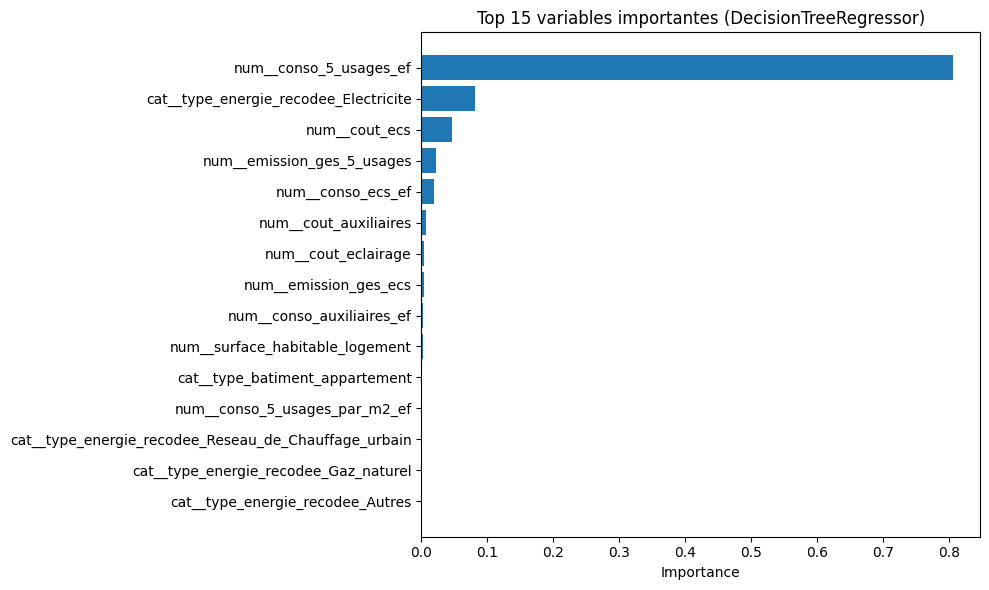

In [74]:
import matplotlib.pyplot as plt

top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance["Feature"].head(top_n),
    feature_importance.iloc[:top_n, 1]
)
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} variables importantes ({best_reg_name})")
plt.xlabel("Importance" if best_reg_name != "LinearRegression" else "Coefficient absolu")
plt.tight_layout()
plt.show()


# sauvegarde final

In [68]:
joblib.dump(best_class_model, f"best_model_classification_{best_class_name}.pkl")
joblib.dump(best_reg_model, f"best_model_regression_{best_reg_name}.pkl")


['best_model_regression_DecisionTreeRegressor.pkl']

deuxième phase nous allons etudier les nouvelles colonnes

In [76]:
donnee_num = donnee_modelisation.select_dtypes(include=np.number)
donnee_cat = donnee_modelisation.select_dtypes(exclude=np.number)

<Axes: >

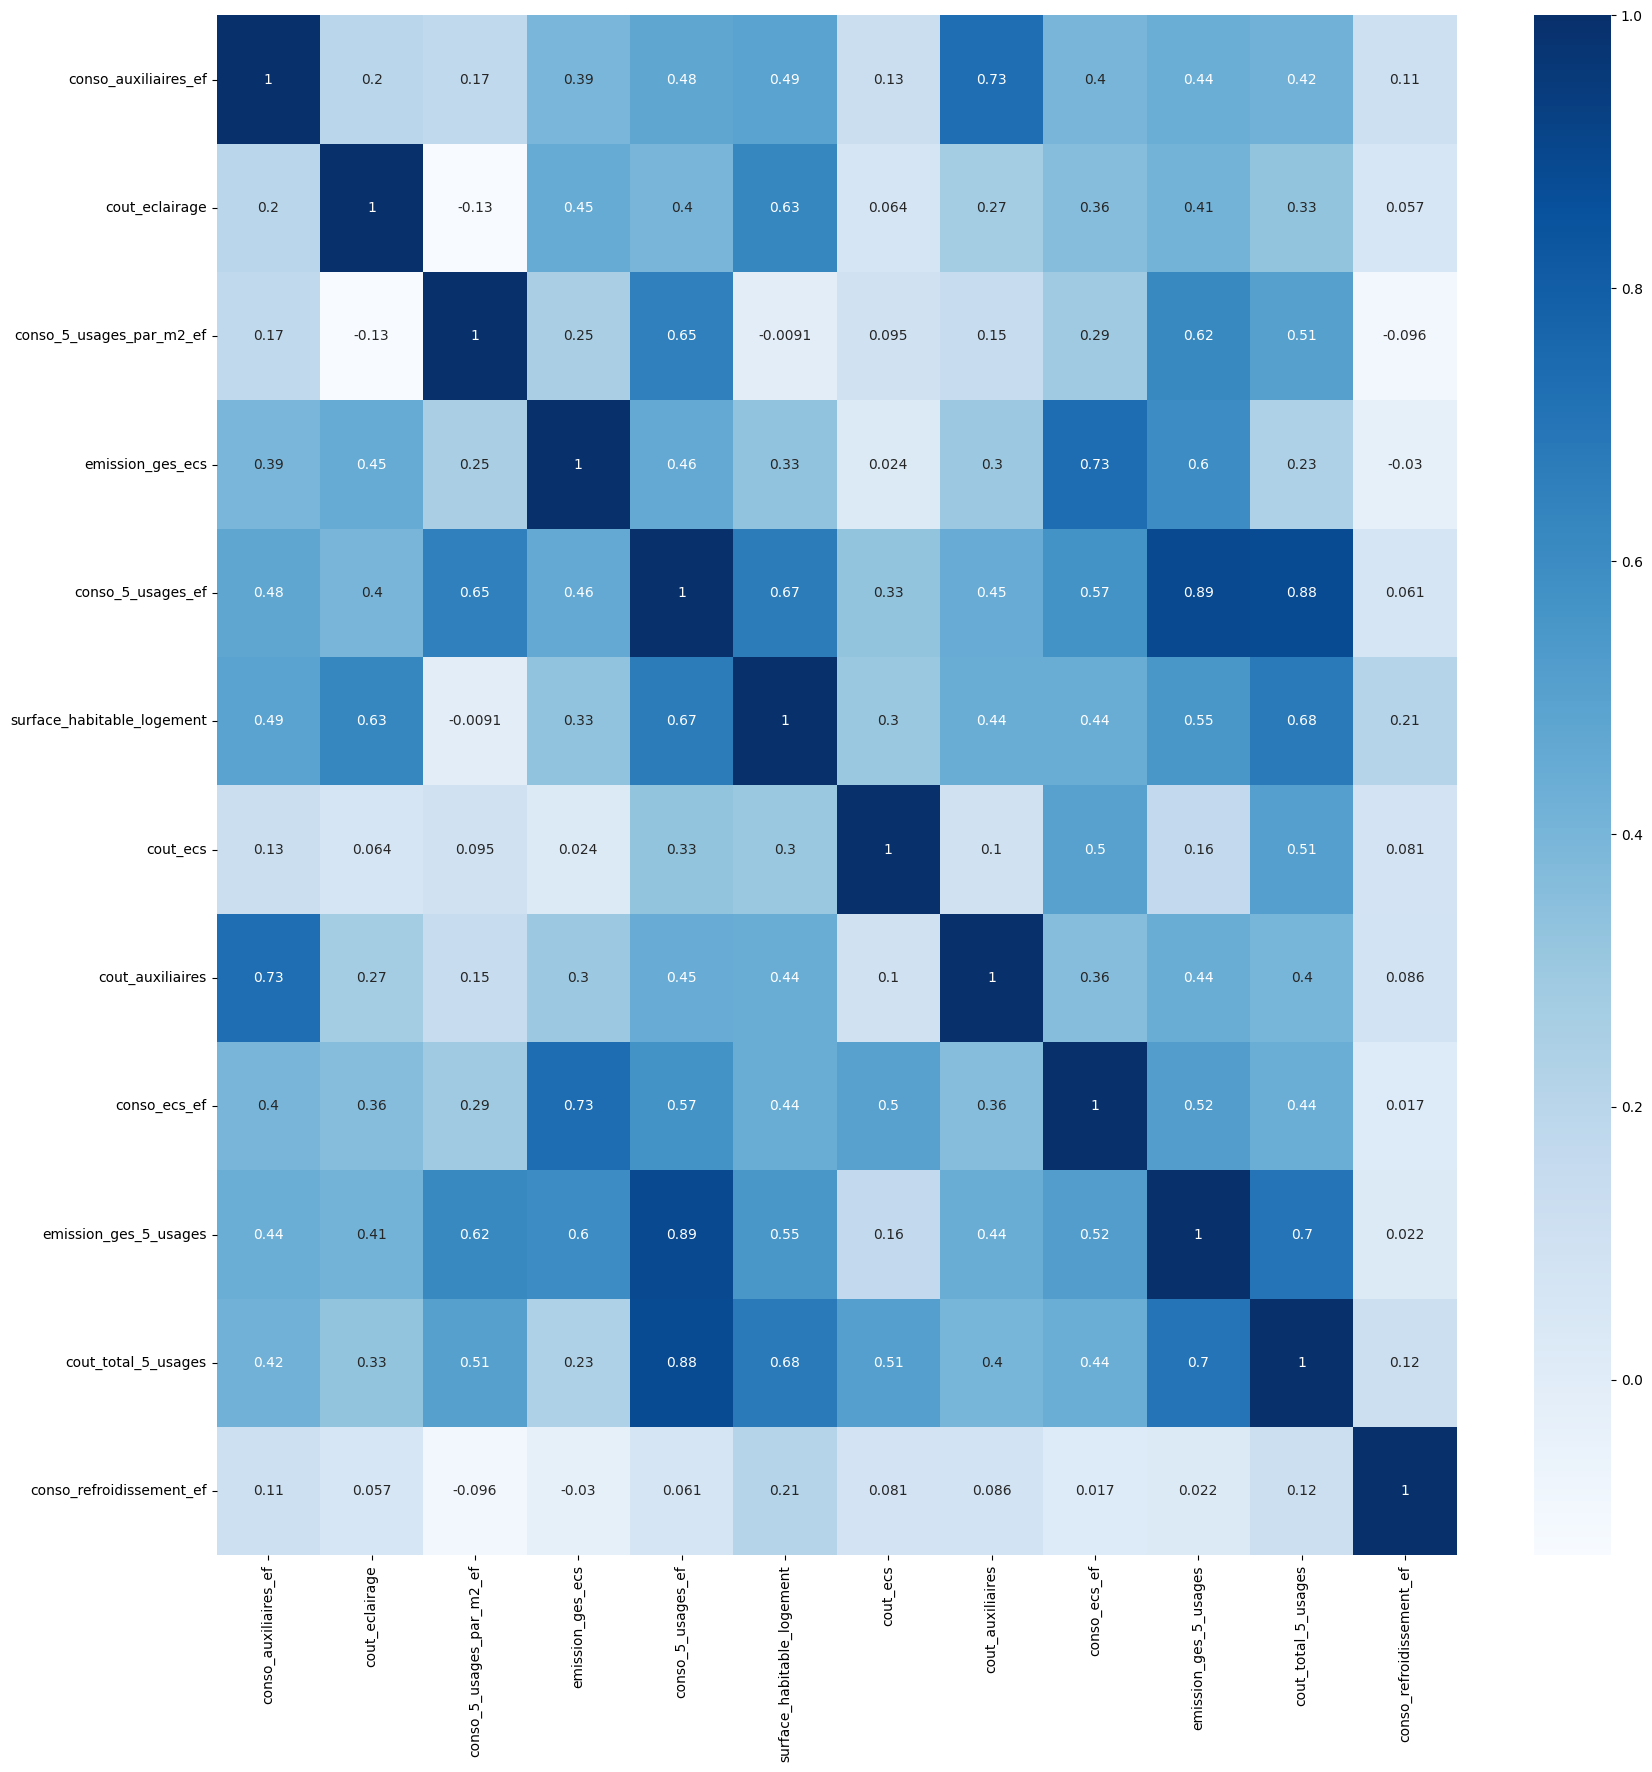

In [79]:
donnee_num_cor = donnee_num.corr()
plt.figure(figsize = [20, 20])
sns.heatmap(donnee_num_cor, annot = True, cmap = "Blues")

In [80]:
cor_pairs = donnee_num_cor.unstack()
sorted_pairs = cor_pairs.sort_values(kind = 'quicksort')
strong_pairs = sorted_pairs[(abs(sorted_pairs) > 0.7) & (abs(sorted_pairs) < 1)]

print(strong_pairs)

cout_total_5_usages    emission_ges_5_usages    0.703018
emission_ges_5_usages  cout_total_5_usages      0.703018
conso_auxiliaires_ef   cout_auxiliaires         0.730150
cout_auxiliaires       conso_auxiliaires_ef     0.730150
conso_ecs_ef           emission_ges_ecs         0.732255
emission_ges_ecs       conso_ecs_ef             0.732255
cout_total_5_usages    conso_5_usages_ef        0.883144
conso_5_usages_ef      cout_total_5_usages      0.883144
                       emission_ges_5_usages    0.890685
emission_ges_5_usages  conso_5_usages_ef        0.890685
dtype: float64


In [81]:
def pairs_redondants(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

#  top pairs
def top_pairs_redondants(df, n=10):
    corr_list = df.abs().unstack()
    labels_to_drop = pairs_redondants(df)
    corr_list = corr_list.drop(labels=labels_to_drop).sort_values(ascending=False)
    return corr_list[0:n]

In [82]:
top = top_pairs_redondants(donnee_num_cor, n=len(donnee_num_cor.columns)**2)
top_df = top.reset_index()
top_df.columns = ['Variable 1', 'Variable 2', 'Correlation']

display(top_df[top_df['Correlation'] > 0.7])

,Variable 1,Variable 2,Correlation
0,conso_5_usages_ef,emission_ges_5_usages,0.890685
1,conso_5_usages_ef,cout_total_5_usages,0.883144
2,emission_ges_ecs,conso_ecs_ef,0.732255
3,conso_auxiliaires_ef,cout_auxiliaires,0.730150
4,emission_ges_5_usages,cout_total_5_usages,0.703018


In [89]:
donnee_cat.columns

Index(['type_batiment', 'etiquette_ges', 'etiquette_dpe',
       'type_energie_recodee'],
      dtype='object')

In [90]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

# Fonction pour calculer Cramér's V
def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    phi2 = chi2 / n
    r, k = table.shape
    return np.sqrt(phi2 / min(k-1, r-1))

# Sélection des variables catégorielles
cat_cols = ['type_batiment', 'etiquette_ges', 'etiquette_dpe', 'type_energie_recodee']

# Stocker les résultats
results = []

# Boucle sur toutes les paires possibles
for i, var1 in enumerate(cat_cols):
    for var2 in cat_cols[i+1:]:
        table = pd.crosstab(donnee_cat[var1], donnee_cat[var2])
        chi2, p, dof, _ = chi2_contingency(table)
        v = cramers_v(donnee_cat[var1], donnee_cat[var2])
        results.append({
            'Variable 1': var1,
            'Variable 2': var2,
            'Chi2': chi2,
            'p-value': p,
            "Cramer's V": v,
            'Significant association': p < 0.05
        })

# Transformer en DataFrame pour visualisation
assoc_df = pd.DataFrame(results)

# Trier par Cramér's V décroissant
assoc_df = assoc_df.sort_values(by="Cramer's V", ascending=False)

# Afficher les associations significatives
assoc_df[assoc_df['Significant association']]

,Variable 1,Variable 2,Chi2,p-value,Cramer's V,Significant association
3,etiquette_ges,etiquette_dpe,691904.160095,0.0,0.515243,True
4,etiquette_ges,type_energie_recodee,348387.218819,0.0,0.447782,True
2,type_batiment,type_energie_recodee,55869.327546,0.0,0.253593,True
5,etiquette_dpe,type_energie_recodee,79841.246611,0.0,0.214362,True
1,type_batiment,etiquette_dpe,26006.288423,0.0,0.173017,True
0,type_batiment,etiquette_ges,17543.745052,0.0,0.142106,True


# dernière phase

In [91]:
donnee_modelisation = pd.read_csv('donnees_ademe_finales_nettoyees_69_final_pret.csv')
donnee_modelisation.shape

(434380, 21)

In [92]:
donnee_modelisation = donnee_modelisation.drop(columns=['date_reception_dpe', 'code_postal_ban', 'adresse_norm', 'latitude','longitude', 'cout_auxiliaires',
                                                        'emission_ges_ecs','emission_ges_5_usages','emission_ges_5_usages','etiquette_ges'])

In [93]:
donnee_modelisation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434380 entries, 0 to 434379
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   conso_auxiliaires_ef        434380 non-null  float64
 1   cout_eclairage              434380 non-null  float64
 2   conso_5_usages_par_m2_ef    434380 non-null  float64
 3   conso_5_usages_ef           434380 non-null  float64
 4   surface_habitable_logement  434380 non-null  float64
 5   cout_ecs                    434380 non-null  float64
 6   type_batiment               434380 non-null  object 
 7   conso_ecs_ef                434380 non-null  float64
 8   etiquette_dpe               434380 non-null  object 
 9   cout_total_5_usages         434380 non-null  float64
 10  conso_refroidissement_ef    434380 non-null  float64
 11  type_energie_recodee        434380 non-null  object 
dtypes: float64(9), object(3)
memory usage: 39.8+ MB


In [94]:
# Variables cibles
target_class = 'etiquette_dpe'
target_reg = 'cout_total_5_usages'

# Séparation X / y
X = donnee_modelisation.drop(columns=[target_class, target_reg])
y_class = donnee_modelisation[target_class]
y_reg = donnee_modelisation[target_reg]

# Colonnes numériques et catégorielles
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipelines de transformation
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ])


## classification

In [95]:
# Dictionnaire des modèles de classification et leurs hyperparamètres
models_class = {
        "RandomForest": (
        RandomForestClassifier(random_state=42, class_weight='balanced'),
        {
            "classifier__n_estimators": [0, 100, 300],
            "classifier__max_depth": [None, 10, 20]
        }
    )
}


In [96]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.3, random_state=42, stratify=y_class
)


best_models_class = {}

for name, (model, params) in models_class.items():
    print(f"\n Optimisation du modèle de classification : {name}")

    # Pipeline avec SMOTE pour équilibrer les classes
    pipe = ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", model)
    ])

    grid = GridSearchCV(
        pipe,
        param_grid=params,
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )

    grid.fit(X_train, y_train)
    best_models_class[name] = grid.best_estimator_

    print(f" Meilleurs paramètres : {grid.best_params_}")
    print(f" Score CV : {grid.best_score_:.4f}")



 Optimisation du modèle de classification : RandomForest


c:\Users\Surface\Documents\Master SISE\ML Python\Projet ML\data\projet-ml\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Surface\Documents\Master SISE\ML Python\Projet ML\data\projet-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Surface\Documents\Master SISE\ML Python\Projet ML\data\projet-ml\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(

 Meilleurs paramètres : {'classifier__max_depth': None, 'classifier__n_estimators': 300}
 Score CV : 0.9565



===  Évaluation du modèle : RandomForest ===
 Accuracy globale : 0.9581

 Rapport de classification :
              precision    recall  f1-score   support

           A       0.96      0.97      0.97      2027
           B       0.91      0.96      0.93      5381
           C       0.99      0.98      0.98     49031
           D       0.97      0.97      0.97     39837
           E       0.95      0.93      0.94     22196
           F       0.85      0.88      0.86      7284
           G       0.88      0.93      0.91      4558

    accuracy                           0.96    130314
   macro avg       0.93      0.95      0.94    130314
weighted avg       0.96      0.96      0.96    130314



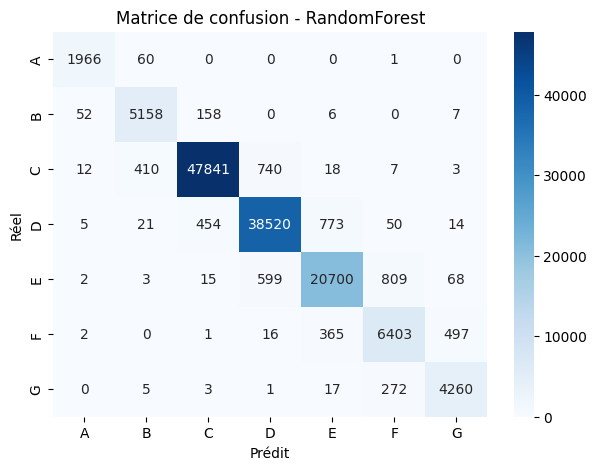


 Classement des modèles de classification :
         Modèle  Accuracy
0  RandomForest  0.958055


In [97]:
# évaluation du modèle
results = []

for name, model in best_models_class.items():
    print(f"\n===  Évaluation du modèle : {name} ===")
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f" Accuracy globale : {acc:.4f}\n")
    
    print(" Rapport de classification :")
    print(classification_report(y_test, y_pred))
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred, labels=sorted(y_class.unique()))
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=sorted(y_class.unique()),
                yticklabels=sorted(y_class.unique()))
    plt.title(f"Matrice de confusion - {name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()
    
    results.append((name, acc))

# Résumé comparatif
results_df = pd.DataFrame(results, columns=['Modèle', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
print("\n Classement des modèles de classification :")
print(results_df)


In [98]:
# sauvegarde du meilleur modèle mis à jour

best_class_name = results_df.iloc[0]['Modèle']
best_class_model = best_models_class[best_class_name]

print(f"\n Meilleur modèle de classification : {best_class_name}")
joblib.dump(best_class_model, f"best_model_classification_{best_class_name}.pkl")
print(f" Modèle sauvegardé : best_model_classification_{best_class_name}.pkl")



 Meilleur modèle de classification : RandomForest
 Modèle sauvegardé : best_model_classification_RandomForest.pkl


## regression

In [99]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error


In [100]:
models_reg = {
    "LinearRegression": (
        LinearRegression(),
        {}
    ),
    "DecisionTreeRegressor": (
        DecisionTreeRegressor(random_state=42),
        {
            "regressor__max_depth": [None, 5, 10, 20, 30, 40, 50],
            "regressor__min_samples_split": [2, 5, 10, 15, 20],
            "regressor__min_samples_leaf": [1, 2, 4]
        }
    )
}


In [101]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.3, random_state=42
)

best_models_reg = {}

for name, (model, params) in models_reg.items():
    print(f"\n Optimisation du modèle de régression : {name}")

    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

    grid = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1, scoring='r2')
    grid.fit(X_train_r, y_train_r)

    best_models_reg[name] = grid.best_estimator_

    print(f" Meilleurs paramètres : {grid.best_params_}")
    print(f" Score CV : {grid.best_score_:.5f}")

# Évaluation finale
for name, model in best_models_reg.items():
    print(f"\n=== Évaluation {name} ===")
    y_pred_r = model.predict(X_test_r)
    print("R² :", r2_score(y_test_r, y_pred_r))
    print("MAE :", mean_absolute_error(y_test_r, y_pred_r))

# Sélection du meilleur
best_reg_name = max(best_models_reg, key=lambda m: r2_score(y_test_r, best_models_reg[m].predict(X_test_r)))
best_reg_model = best_models_reg[best_reg_name]
print(f"\n Meilleur modèle de régression : {best_reg_name}")



 Optimisation du modèle de régression : LinearRegression
 Meilleurs paramètres : {}
 Score CV : 0.91249

 Optimisation du modèle de régression : DecisionTreeRegressor
 Meilleurs paramètres : {'regressor__max_depth': 30, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 20}
 Score CV : 0.96775

=== Évaluation LinearRegression ===
R² : 0.9131376911100504
MAE : 140.52377865001878

=== Évaluation DecisionTreeRegressor ===
R² : 0.9690358459056202
MAE : 46.29292439851036

 Meilleur modèle de régression : DecisionTreeRegressor


# sauvegarde final

In [102]:
joblib.dump(best_class_model, f"best_model_classification_{best_class_name}.pkl")
joblib.dump(best_reg_model, f"best_model_regression_{best_reg_name}.pkl")


['best_model_regression_DecisionTreeRegressor.pkl']